## Contains experiments on the Heart-rate dataset

In [366]:
# My imports
import numpy as np
import pandas as pd
import os
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
from adahessian import Adahessian, get_params_grad
import torch.optim.lr_scheduler as lr_scheduler
import math

# Other imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data_utils
import warnings
import matplotlib.pyplot as plt
# import shap


In [367]:
dataset= "../BQR/Datasets/Datasets/Classification/heart.csv"
x_cols = list(range(13))
y_col = 13

attribute_index = 7 # This controls which attribute is allowed to vary
attribute_name = "Max Heart Rate" # Name of the attribute, used in the plots
latent_name = "Heart Disease" # Name of the function, used in the plots
# The other attributes are replaced by the median value of the attribute
Scaler= StandardScaler()
batch_is= 64

total_epochs = 20

In [368]:
def create_xy(dataset, attribute_columns, target_column, delim, split_ratio, ditch_head=True):
    with open(dataset, 'r') as f:
        lines = f.readlines()
    if ditch_head:
        lines = lines[1:]
    X = []
    Y = []
    for line in lines:
        while len(line) > 0 and line[-1] == "\n":
            line = line[:len(line)-1]
        split_array = line.split(delim)
        all_columns = []
        for value in split_array:
            if value !="" and value !=" ":
                all_columns.append(value)
        if len(all_columns)==0:
            break
        point = []
        for i in attribute_columns:
            point.append(float(all_columns[i]))
        X.append(point)
        Y.append(float(all_columns[target_column]))
    X_arr = np.asarray(X)
    X_unscaled = np.asarray(X)
    Scaler.fit(X_arr)
    X_arr = Scaler.transform(X_arr)
    Y_arr = np.asarray(Y)
    thresh = 0
    Y_arr_binary = np.where(Y_arr<=thresh,0,1)
    unique, counts = np.unique(Y_arr_binary, return_counts=True)
    x_train, x_test, y_train, y_test = train_test_split(X_arr, Y_arr_binary, test_size = split_ratio)
    return x_train, x_test, y_train, y_test, Y_arr, X_arr, X_unscaled

In [369]:
# Network definition:
# torch.manual_seed(111)

class Network(nn.Module):
    def __init__(self, indim):
        super(Network,self).__init__()
        self.l1 = nn.Linear(indim,100)
        self.l2 = nn.Linear(100,10)
        self.l3 = nn.Linear(10,9)
    
    def forward(self,x):
        x = F.tanh(self.l1(x))
        x = F.tanh(self.l2(x))
        x = self.l3(x)
        return x

# def tiltedLC(x, y, tau, h):
#     e= y-x # errors
#     ind= (torch.sign(e)+1)/2 # the division in the log-cosh is only about the origin
#     quantFactor= (1-tau)*(1-ind) + tau*ind
#     loss= quantFactor*torch.log(torch.cosh(e))
#     loss= torch.mean(loss)
#     return loss

# def check_loss(x, y, tau): 
#     e = y-x
#     # below I(e<0)
#     ind = (torch.sign(-e)+1)/2
#     loss = torch.mean(e*(tau-ind))
#     return loss

# def customLoss(y_true, y_pred, h):
#     ind_losses = []
#     for i,j in enumerate(all_qs):
#         single_quantile_loss = tiltedLC(y_pred[i], y_true, j, h)
#         # single_quantile_loss = tiltedLC(y_true[:,0],y_pred[:,i*4760:i*4760+4760], j, h)
#         ind_losses.append(single_quantile_loss)
#     zero = torch.Tensor([0]).to(device)
#     # dummy1 = y_pred[:,1:] - y_pred[:,:-1]
#     # dummy2 = penalty * torch.mean(torch.max(zero,-1.0 * dummy1))
#     total_loss  = torch.mean(torch.stack(ind_losses))
#     return total_loss


def barePDF(x, tau):
    # x is a torch tensor, tau is a float
    ind= (torch.sign(x)+1)/2 # mask about the origin
    quantFactor= (1-tau)*(1-ind) + tau*ind
    return 2/math.pi*torch.cosh(x).pow_(-1)*quantFactor

def bareCDF(yhat, tau):
    # yhat is a torch tensor, tau is a float
    ind= (torch.sign(yhat)+1)/2 # mask about the origin
    quantFactor= (1-tau)*ind + tau*(1-ind)
    val= tau+4*quantFactor/math.pi*torch.atan(torch.tanh(yhat/2))
    # print("bareCDF val: {}".format(val))
    return val

def quantilePDF(x, qs):
    # x is a torch tensor, qs is a list of floats
    quantilePDs= []
    for q in qs:
        quantilePDs.append(barePDF(x, q))
    return quantilePDs

def quantileCDF(yhat, qs):
    # yhat is a torch tensor, qs is a list of floats
    quantileCDs= []
    for q in qs:
        quantileCDs.append(bareCDF(yhat, q))
    return quantileCDs 

def baresBQR(y, yhat, tau):
    # y and yhat are torch tensors, tau is a float
    val= y*torch.log(1-bareCDF(yhat, tau))+(1-y)*torch.log(bareCDF(yhat, tau))
    # print("bareBQR val: {}".format(val))
    return val

def sBQR(y, yhat, qs):
    # y and yhat are torch tensors and qs is a list of floats
    # yhat would be a [batch,9] output vector, have to index it accordingly
    quantilesBQRs= []
    for idx, q in enumerate(qs):
        quantilesBQRs.append(baresBQR(y, yhat[:,idx], q))
    return quantilesBQRs

class sBQRL(nn.Module):
    def __init__(self):
        super(sBQRL, self).__init__()
    
    def forward(self, y, yhat, qs, model, loader):
        return torch.mean(torch.cat(sBQR(y, yhat, qs))) + 0.0025*regularization(qs, model, loader)

def regularization(qs, model, loader):
    """
    qs: Quantiles to be learnt
    model: Current state of the torch model being trained
    loader: The current Torch dataLoader that is being iterated over
    """
    outerSum= 0
    for inputs, labels in loader:
        inputs= inputs.to(device)
        labels= labels.to(device)
        outputs= model(inputs) # again, outputs would consist of a [batch, 9*outdim] tensor
        innerSum= 0
        for idx, q in enumerate(qs):
            if idx+1 != 9:
                innerSum+= torch.max(torch.zeros_like(outputs[:,idx]), outputs[:,idx]-outputs[:,idx+1])
        outerSum+= torch.sum(innerSum)
    return outerSum

In [370]:
X_train,X_val,y_train,y_val, data_Y, data_X_scaled, data_X_unscaled = create_xy(dataset, x_cols, y_col, ",", 0.4)
shap_x_train = X_train.copy()
shap_x_val = X_val.copy()
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)
train_dataset = data_utils.TensorDataset(X_train, y_train)
test_dataset = data_utils.TensorDataset(X_val, y_val)
train_loader = data_utils.DataLoader(train_dataset, batch_size =batch_is, pin_memory=True,shuffle=True,num_workers = 1)
test_loader = data_utils.DataLoader(test_dataset,batch_size =batch_is,pin_memory=True,shuffle = False,num_workers = 1)

In [371]:
device= ('cuda' if torch.cuda.is_available() else 'cpu')
indim = X_train.shape[1]
model = Network(indim)
criterion= sBQRL()
model = model.to(device)
h= 0.4

In [372]:
lr_is = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr = lr_is)
all_qs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
all_qs = torch.Tensor(all_qs).to(device)
mean_is = 0
std_is = 1
penalty = 1
alpha = 0.0

In [373]:
def train(model,trainLoader, testLoader, epochs):
    train_error= []
    test_error= []
    model.train()
    
    for epoch in range(epochs):
        for i, j in enumerate(trainLoader):
            inputs,labels = j[0],j[1]
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            op_qs = model(inputs)
            # print("outputs: {}".format(op_qs))
            lossQ = criterion(labels, op_qs, all_qs, model, trainLoader)
            print("loss: {}".format(lossQ.item()))
            lossQ.backward()
            optimizer.step()
        train_error.append(lossQ/len(trainLoader))

        with torch.no_grad():
            for i, j in enumerate(testLoader):
                inputs,labels = j[0],j[1]
                inputs = inputs.to(device)
                labels = labels.to(device)
                op_qs = model(inputs)
            lossQ = criterion(labels, op_qs, all_qs, model, testLoader)
            test_error.append(lossQ/len(testLoader))
        
    return train_error, test_error

In [374]:
train_error, test_error= train(model, train_loader, test_loader, 10)

/home/aryamanj/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


loss: -0.4484429955482483
loss: -0.6430568695068359
loss: -0.7284963130950928
loss: -0.7755413055419922
loss: -0.8347538709640503
loss: -0.8705507516860962
loss: -0.8805221915245056
loss: -0.919942319393158
loss: -0.9807785153388977
loss: -0.9904167652130127
loss: -1.0401978492736816
loss: -1.0212563276290894
loss: -1.0960065126419067
loss: -1.096319556236267
loss: -1.1335128545761108
loss: -1.1691104173660278
loss: -1.2075392007827759
loss: -1.276624083518982
loss: -1.2626316547393799
loss: -1.3858959674835205
loss: -1.3955161571502686
loss: -1.4607815742492676
loss: -1.4453178644180298
loss: -1.6243937015533447
loss: -1.6255813837051392
loss: -1.6986528635025024
loss: -1.7252938747406006
loss: -1.736358404159546
loss: -1.892881989479065
loss: -2.0515058040618896


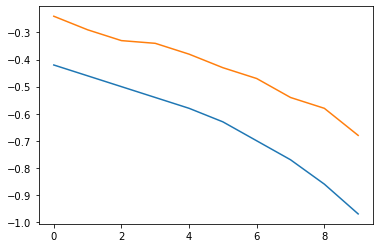

In [375]:
test_error= [float("{:.2f}".format(x)) for x in test_error]
train_error= [float("{:.2f}".format(x)) for x in train_error]
plt.plot(range(10), test_error)
plt.plot(range(10), train_error)

In [376]:
new_scaler = StandardScaler()
new_scaler.fit(data_X_unscaled)

col_index = attribute_index
attribute_array = np.arange(min(data_X_unscaled[:,col_index]), max(data_X_unscaled[:,col_index]),1)

test_inputs  = []
med_values_left = []
med_values_right = []

for i in range(len(data_X_unscaled[0])):
    if i<col_index:
        med_values_left.append(np.mean(data_X_unscaled[:,i]))
    elif i>col_index:
        med_values_right.append(np.mean(data_X_unscaled[:,i]))

for i in range(len(attribute_array)):
    test_inputs.append(np.concatenate([med_values_left,attribute_array[i],med_values_right], axis=None))

scaled_input = new_scaler.transform(test_inputs)
X_tens = torch.Tensor(scaled_input)
y_tens = torch.Tensor([0]*len(scaled_input)) # irrelevant 

func_dataset = data_utils.TensorDataset(X_tens, y_tens)
func_loader = data_utils.DataLoader(func_dataset, batch_size =1024, pin_memory=True,shuffle=False,num_workers = 1)

In [377]:
model.eval()
outputs = [[] for i in range(9)]
avg = []
with torch.no_grad():
    for i,j in func_loader:
        inputs,labels = i.to(device),j.to(device)
        op_qs = model(inputs)
        for itemset in op_qs.detach():
            total = 0
            for q in range(9):
                val = itemset[q].item()
                total+=val
                outputs[q].append(val)
            avg.append(total/9)


# def test(model,loader):
#     lossVals= []
#     model.eval()
    
#     for i, j in enumerate(loader):
#         inputs,labels = j[0],j[1]
#         inputs = inputs.to(device)
#         labels = labels.to(device)
#         op_qs = model(inputs)
#         lossQ = customLoss(op_qs, labels, h)
#         lossVals.append(lossQ)
#     return lossVals

/home/aryamanj/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [378]:
# new_tau = []
# for i in range(1,20):
#     new_tau.append(i*0.05)
# available_tau = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
# interpolated = []
# for i in new_tau:
#     interpolated.append(smoothed_quantile(i, available_tau, outputs))

In [379]:
print("Median of features")
for i in med_values_left:
    print(i)
print("Varying Feature:", attribute_name)
for i in med_values_right:
    print(i)

Median of features
54.366336633663366
0.6831683168316832
0.966996699669967
131.62376237623764
246.26402640264027
0.1485148514851485
0.528052805280528
Varying Feature: Max Heart Rate
0.32673267326732675
1.0396039603960396
1.3993399339933994
0.7293729372937293
2.3135313531353137


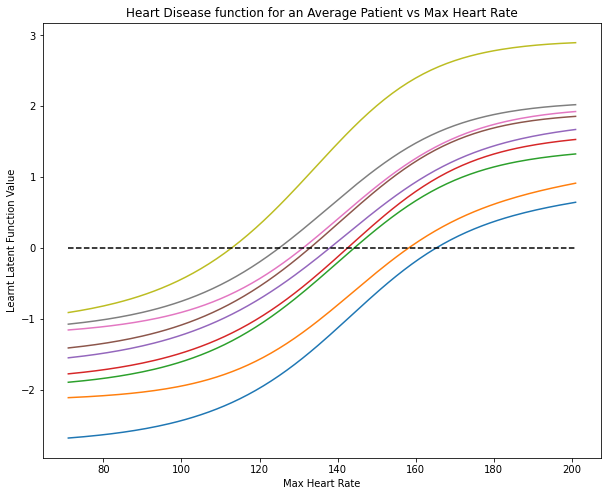

In [380]:
plt.figure(figsize=(10,8))
plt.title(latent_name + " function for an Average Patient vs " + attribute_name)
for i in range(9):
    plt.plot(attribute_array, outputs[i],label="Q0."+str(i+1))
# plt.ylim(0.5, 0.6)
plt.plot([min(attribute_array), max(attribute_array)],[0,0], linestyle="dashed", c="k")
plt.ylabel("Learnt Latent Function Value")
plt.xlabel(attribute_name)
# plt.legend(ncol=2,handleheight=2.4, labelspacing=0.05)
plt.show()

Interpolated Quantiles


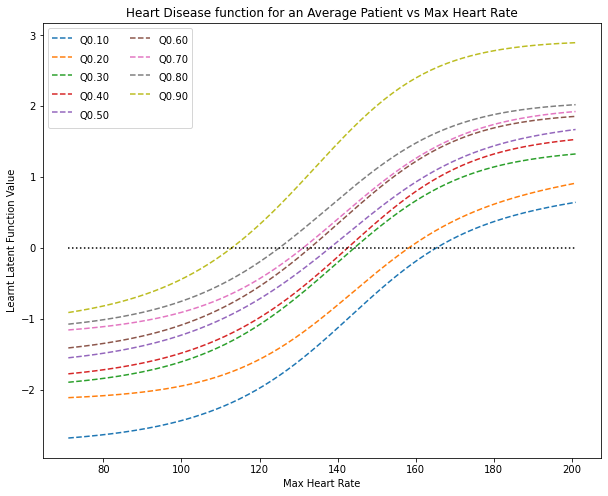

In [381]:
print("Interpolated Quantiles")

plt.figure(figsize=(10,8))
plt.title(latent_name + " function for an Average Patient vs "+attribute_name)
for i in range(9):
    plt.plot(attribute_array, outputs[i],label="Q{:.2f}".format(all_qs[i]), linestyle="dashed")
# plt.ylim(0.8,1.0)
plt.plot([min(attribute_array), max(attribute_array)],[0,0], linestyle="dotted", c="k")
plt.ylabel("Learnt Latent Function Value")
plt.xlabel(attribute_name)
plt.legend(ncol=2,handleheight=2.4, labelspacing=0.05)
plt.show()